In [57]:
import requests
import xml.etree.ElementTree as ET
import numpy as np
from equilibrator_api import ComponentContribution
import pandas as pd
import pickle
import os

cc = ComponentContribution()
s = requests.Session() # create 

In [84]:
# from Kegg id to inchi_key

kegg_id = 'C00031'
compound = cc.get_compound("kegg:"+kegg_id)

# look up the concentration of the compound in datanator
try:
    r = s.get('https://api.datanator.info/metabolites/concentration_only/?inchi_key='+compound.inchi_key)
    concentration = np.mean(list(map(float, r.json()[1]['concentrations']['concentration']))) # are these all in uM?
except:
    concentration = 1 # default concentration value
concentration

1707.3333333333333

In [332]:
def get_metabolite(kegg_id, recache=False):
    try:
        with open(os.getcwd()+'/src/kinetic_estimator/datanator_cache.pickle', 'rb') as handle:
            datanator_cache = pickle.load(handle)
    except:
        datanator_cache = {}

    if kegg_id in datanator_cache and not recache:
        return datanator_cache[kegg_id]
    
    else:
        compound = cc.get_compound("kegg:"+kegg_id)
        try:
            r = s.get('https://api.datanator.info/metabolites/concentration_only/?inchi_key='+compound.inchi_key)
            concentration = np.array(list(map(float,r.json()[1]['concentrations']['concentration']))) # are these all in uM?
            units = np.array(list(map(lambda x: x.replace('&#181;','u'), r.json()[1]['concentrations']['concentration_units'])))
            concentration = np.mean(concentration[units=='uM']) # take the mean of only the uM
        except:
            try:
                r = s.get('https://api.datanator.info/metabolites/concentrations/similar_compounds/?inchikey='+compound.inchi_key+'&threshold=0.8&target_species=Escherichia%20coli')
                concentration = np.array(list(map(float,sum([[y['concentration'] for y in x['concentrations']] for x in r.json()],[]))))
                units = np.array(list(map(lambda x: x.replace('&#181;','u'), sum([[y['concentration_units'] if 'concentration_units' in y else y['unit'] for y in x['concentrations'] ] for x in r.json()],[]))))
                if len(units)>0:
                    concentration[[units=='M']] = concentration[[units=='M']]*10e6
                    concentration = np.mean(concentration[units=='uM']) # take the mean of only the uM
                else:
                    concentration = np.nan
            except Exception as e:
                concentration = np.nan # default concentration value
        
        datanator_cache[kegg_id] = concentration
        with open(os.getcwd()+'/src/kinetic_estimator/datanator_cache.pickle', 'wb') as handle:
            pickle.dump(datanator_cache, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return concentration

In [48]:
# get kegg ids to look up. this could be from the Species spreadsheet; using full_reports for now
compounds = np.unique(sum([pd.read_csv('src/kinetic_estimator/'+file+'.csv')['substrates'].to_list() for file in ['full_report_kcats','full_report_kcats_missing','full_report_kis']],[]))

In [ ]:
all_concentrations = np.array(list(map(lambda c: get_metabolite(c, True), compounds)))

(array([ 2.,  1.,  2.,  4., 12., 13., 36., 11.,  9.,  1.]),
 array([-1.7212464 , -0.99939969, -0.27755297,  0.44429374,  1.16614045,
         1.88798717,  2.60983388,  3.33168059,  4.05352731,  4.77537402,
         5.49722073]),
 <BarContainer object of 10 artists>)

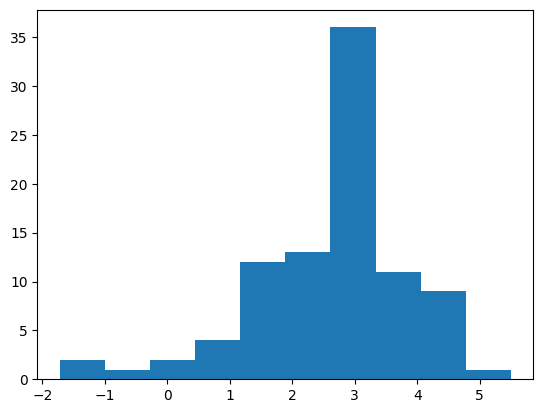

In [334]:
import matplotlib.pyplot as plt
plt.hist(np.log10(all_concentrations[~np.isnan(all_concentrations)]))